In [1]:
import pandas as pd
import numpy as np
import csv

import requests
from io import StringIO

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

# Problem B

##  Imputing the missing value

In [2]:
attributes = ['age','gender','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G','class']
df_2 = pd.read_csv("./Indian Liver Patient Dataset (ILPD).csv", encoding='utf-8',header = None, names = attributes)

In [4]:
df_2.isnull().sum()

age        0
gender     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/G        4
class      0
dtype: int64

In [5]:
df_2['A/G'] = df_2['A/G'].replace(np.nan,df_2['A/G'].mean())

In [6]:
df_2 = pd.get_dummies(df_2, prefix='gender')
df_2 = df_2.drop(columns = 'gender_Female')

In [7]:
df_2 = df_2.astype(float)

In [8]:
df_2 = df_2 / df_2.max() # rescale attributes [0, 1]
df_2['class'] = df_2['class'].apply(lambda x: 0 if x == 0.5 else x)

In [9]:
df_2 = df_2[['age','gender_Male','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G','class']]

## split data

In [10]:
df_2 = df_2.sample(frac = 1, random_state = 7021).reset_index(drop = True)
N_train_2 = round(0.75 * df_2.shape[0])
X_2 = df_2.iloc[:,:-1]
y_2 = df_2.iloc[:, -1]
X_train_2 = X_2.iloc[0:N_train_2,:]
X_test_2 = X_2.iloc[N_train_2:,:]
y_train_2 = y_2.iloc[:N_train_2]
y_test_2 = y_2.iloc[N_train_2:]

In [11]:
N_2, P_2 = X_train_2.shape

## cross validation

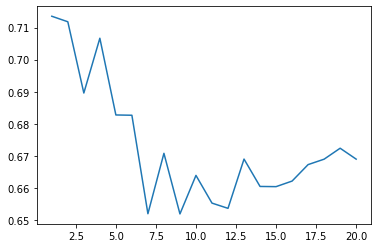

The best accuracy is 0.7135573239021515 and the corresponding depth is 1


In [15]:
%matplotlib inline 
from sklearn.model_selection import cross_val_score

score_list = []
depths = []

for dep in range(1,21):
    depths.append(dep)
    clf_cross = DecisionTreeClassifier(
        max_depth = dep, max_leaf_nodes = 2**dep, random_state = 7021)
    scores = cross_val_score(clf_cross, X_2, y_2, cv=5)
    score_list.append(scores.mean())

plt.plot(depths,score_list)
plt.show()

print('The best accuracy is', max(score_list), 'and the corresponding depth is', score_list.index(max(score_list))+1)

## CART

<IPython.core.display.Javascript object>


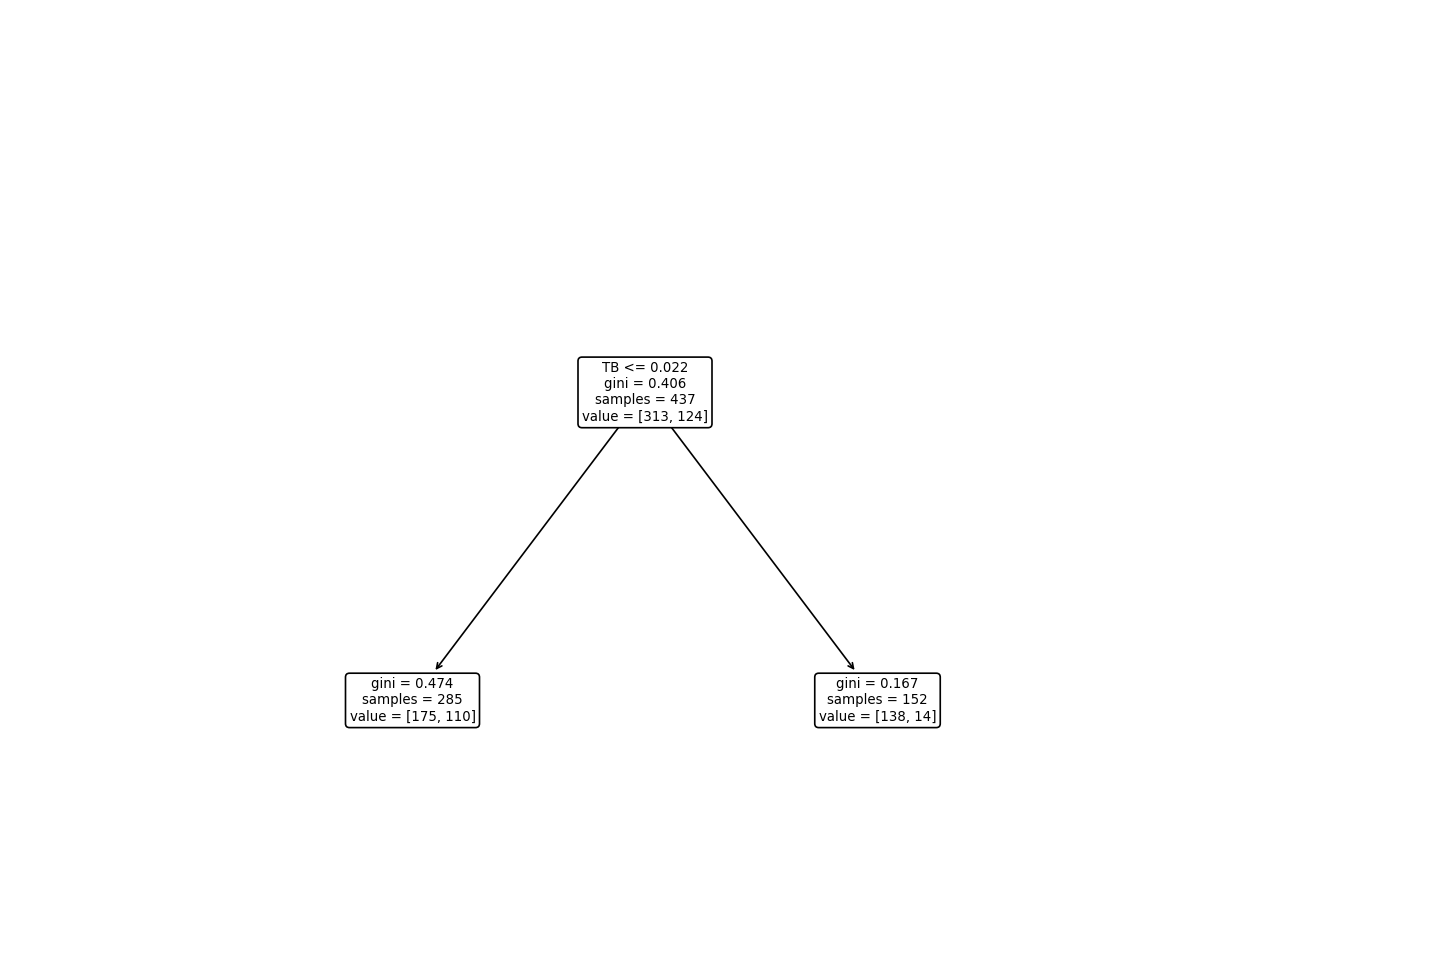

In [20]:
depth = 1
clf_2 = DecisionTreeClassifier(
    max_depth = depth, max_leaf_nodes = 2**depth, random_state = 7021)
clf_2.fit(X_train_2, y_train_2)
fig = plt.figure(figsize = (12, 8))
_ = plot_tree(
    clf_2, filled = False, fontsize = 8, rounded = True, 
    feature_names = attributes[0:-1])
fig.savefig('CART.png')

In [21]:
print(export_text(clf_2, feature_names = attributes[0:-1]))

|--- TB <= 0.02
|   |--- class: 0.0
|--- TB >  0.02
|   |--- class: 0.0



In [22]:
children_left_2 = clf_2.tree_.children_left
children_right_2 = clf_2.tree_.children_right
feature_2 = clf_2.tree_.feature
threshold_2 = clf_2.tree_.threshold

In [25]:
def find_path(root, path, x, children_left, children_right):
    path.append(root)
    if root == x:
        return True
    left = False
    right = False
    if (children_left[root] != -1):
        left = find_path(children_left[root], path, x, children_left, children_right)
    if (children_right[root] != -1):
        right = find_path(children_right[root], path, x, children_left, children_right)
    if left or right:
        return True
    path.remove(root)
    return False

def get_rule(path, children_left, attributes, feature, threshold):
    mask = ''
    for idx, node in enumerate(path):
        # filter out the leaf node
        if idx != len(path) - 1:
            # left or right branch node
            if (children_left[node] == path[idx + 1]):
                mask += "('{}' <= {:.2f}) \t ".format(
                    attributes[feature[node]], threshold[node])
            else:
                mask += "('{}' > {:.2f}) \t ".format(
                    attributes[feature[node]], threshold[node])
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "").strip()
    return mask

In [26]:
leaf_id = np.unique(clf_2.apply(X_train_2))

paths = {}
for leaf in leaf_id:
    path_leaf = []
    find_path(0, path_leaf, leaf, children_left_2, children_right_2)
    paths[leaf] = path_leaf

CART_rules = {}
for leaf in paths:
    CART_rules[leaf] = get_rule(paths[leaf], children_left_2, attributes[0:-1], feature_2, threshold_2)

In [27]:
leaf_id

array([1, 2], dtype=int64)

In [28]:
CART_rules

{1: "('TB' <= 0.02)", 2: "('TB' > 0.02)"}

In [29]:
total_nodes_2 = clf_2.tree_.node_count
leaf_nodes_2 = round(total_nodes_2 / 2)
branch_nodes_2 = total_nodes_2 // 2

In [30]:
initial_a = np.array([i for i in clf_2.tree_.feature if i != -2])
initial_a

array([2], dtype=int64)

In [31]:
initial_b = np.array([i for i in clf_2.tree_.threshold if i != -2])
initial_b

array([0.022])

In [34]:
clf_2.score(X_train_2, y_train_2)

0.7162471395881007

In [33]:
clf_2.score(X_test_2, y_test_2)

0.7054794520547946

### Rules and performance of CART

In [36]:
print('The decision rules in CART is ', CART_rules)
print('\nThe in-sample performance in CART is', clf_2.score(X_train_2, y_train_2))
print('\nThe out-of-sample performance in CART is', clf_2.score(X_test_2, y_test_2))

The decision rules in CART is  {1: "('TB' <= 0.02)", 2: "('TB' > 0.02)"}

The in-sample performance in CART is 0.7162471395881007

The out-of-sample performance in CART is 0.7054794520547946


## OCT

Based on the structure of CART, the depth of OCT is also 1.

After respectively testing on alpha = 0.3, 0.5, 0.6 and epsilon = 0.1, 0.01, 0.0001, 10e-7, 10e-8, I find that the best accuracy is based on alpha = 0.5 and epsilon = 0.1.

In [38]:
alpha = 0.5
K = 2
Y_2 = np.zeros([N_2, K], dtype = int) - 1
Y_2[X_train_2.index, y_train_2.astype(int)] = 1
Y_2.shape

(437, 2)

In [40]:
import os
os.add_dll_directory(os.path.join(os.getenv('GUROBI_HOME'), 'bin'))

from gurobipy import *
model = Model('mip1')

# declare decision variables

# d: [# branch nodes], whether a branch node applies a split or not
d = model.addVars(branch_nodes_2 ,vtype = GRB.BINARY, name = "d") # ∈ {0, 1}
# split criterion: ax < b / ax >== b
# a: [# branch nodes, p], b: [# branch nodes]
a = model.addVars(branch_nodes_2, P_2, vtype = GRB.BINARY, name = 'a') # ∈ {0, 1}
b = model.addVars(branch_nodes_2 ,vtype = GRB.CONTINUOUS, name = "b")

# l: [# leaf nodes], whether a leaf node contains any points or not
l = model.addVars(leaf_nodes_2, vtype = GRB.BINARY, name = "l") # ∈ {0, 1}
# z: [# points, # branch nodes], a point is assigned to which leaf node
z = model.addVars(N_2, leaf_nodes_2, vtype = GRB.BINARY, name = "z") # ∈ {0, 1}

# N_kt: [# labels, # leaf nodes], number of points labelled for class k in a leaf node
N_kt = model.addVars(K, leaf_nodes_2, vtype = GRB.INTEGER, name = "N_kt")
# N_t: [# leaf nodes], number of points in the leaf
N_t = model.addVars(leaf_nodes_2, vtype = GRB.INTEGER, name = "N_t")

# c_kt: [# labels, # leaf nodes], whether predicted label is label k for a leaf node
c_kt = model.addVars(K, leaf_nodes_2, vtype = GRB.BINARY, name = "c") # ∈ {0, 1}
# L: [# leaf nodes], misclassification loss for a leaf node
L = model.addVars(leaf_nodes_2, vtype = GRB.INTEGER, name = "L")

Using license file C:\Users\Ke Xu\gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-09


In [41]:
# warm start using the results of CART algorithm
for t in range(branch_nodes_2):
    a[t, initial_a[t]].start = 1
    b[t].start = initial_b[t]

model.update()

In [42]:
# baseline accuracy by predicting the dominant label for the whole dataset
L_hat = y_train_2.value_counts().max()/y_train_2.shape[0]
L_hat

0.7162471395881007

In [43]:
# declare the objective
model.setObjective(L.sum()/L_hat + alpha * d.sum(), GRB.MINIMIZE)

In [44]:
def get_parent(i, depth = 2):
    assert i > 0, "No parent for Root"
    assert i <= 2 ** (depth + 1) - 1, "Error! Total: {0}; i: {1}".format(
        2 ** (depth + 1) - 1, i)
    return int((i - 1)/2)
# constraint set 1 
for t in range(branch_nodes_2):
    model.addConstr(a.sum(t, '*') == d[t]) # sum(a_tj for j in P) = d_t
    b[t].setAttr(GRB.Attr.LB, 0) # b_t >= 0
    model.addConstr(b[t] <= d[t]) # b_t <= d_t
    model.addConstr(d[t] == 1) # d_t = 1 (assume all the branch applies a split)

# constraint set 2
for t in range(1, branch_nodes_2): # exception: root
    model.addConstr(d[t] <= d[get_parent(t)]) # d_t <= d_p(t)


In [45]:
# constraint set 3
for i in range(N_2):
    model.addConstr(z.sum(i, '*') == 1) # sum(z_it for t in T_L)

# constraint set 4
N_min = 1
for t in range(leaf_nodes_2):
    model.addConstr(l[t] == 1) # l_t == 1 (assume leaf contains points)
    for i in range(N_2):
        model.addConstr(z[i, t] <= l[t]) # z_it <= l_t
    model.addConstr(z.sum('*', t) >= N_min * l[t]) # sum(z_it for i in N) >= N_min * l_t

In [52]:
depth = 1
all_branch_nodes = list(reversed(range(branch_nodes_2)))
depth_dict = {}
for i in range(depth):
    depth_dict[i] = sorted(all_branch_nodes[-2**i:])
    for j in range(2**i):
        all_branch_nodes.pop()
depth_dict

{0: [0]}

In [53]:
all_leaf_nodes = list(range(leaf_nodes_2))
branch_dict = {}
for i in range(branch_nodes_2):
    for k in range(depth):
        if i in depth_dict[k]:
            floor_len = len(depth_dict[k])
            step = 2**depth // floor_len
            sliced_leaf = [all_leaf_nodes[i:i+step] for i in range(0, 2**depth, step)]
            idx = depth_dict[k].index(i)
            branch_dict[i] = sliced_leaf[idx]
        else:
            continue
branch_dict

{0: [0, 1]}

In [54]:
epsilon = 0.1
# constraint set 5
for i in range(N_2):
    for tl in range(leaf_nodes_2):
        for tb in range(branch_nodes_2):
            if tl in branch_dict[tb]:
                length = len(branch_dict[tb])
                idx = branch_dict[tb].index(tl)
                # left-branch ancestors: 
                # np.dot(a_m.T, (x_i + mu))<= b_m + (1 + mu)(1- z_it)
                if idx+1 <= length//2:
                    model.addConstr(
                        sum(a.select(tb, '*') * X_train_2.iloc[i, :]) + epsilon 
                        <= b[tb] + (1 + epsilon) * (1 - z[i, tl]))
                # right-branch ancestors: 
                # np.dot(a_m.T, x_i) >= b_m - (1- z_it)
                elif idx+1 > length//2:
                    model.addConstr(
                        sum(a.select(tb, '*') * X_train_2.iloc[i, :]) 
                        >= b[tb] - (1 - z[i, tl]))
            else:
                continue

In [55]:
# constraint set 6, 7 & 8
for t in range(leaf_nodes_2):
    
    # constraint set 8
    model.addConstr(L[t] >= 0) # L_t >= 0
    for k in range(K):
        # L_t >= N_t - N_kt - n(1 - c_kt)
        model.addConstr(L[t] >= N_t[t] - N_kt[k, t] - N_2 * (1 - c_kt[k, t])) 
        # L_t <= N_t - N_kt + n * c_kt
        model.addConstr(L[t] <= N_t[t] - N_kt[k, t] + N_2 * c_kt[k, t]) 
        
        # constraint set 6
        # N_kt = 1/2 sum((1 + Y_ik)z_it for i in N)
        model.addConstr(N_kt[k, t] == 1/2 * sum(z.select('*', t) * (Y_2[:, k] + 1))) 
    
    model.addConstr(N_t[t] == z.sum('*', t)) # N_t = sum(z_it for i in n)
    # constraint set 7
    model.addConstr(c_kt.sum('*', t) == l[t]) # l_t = sum(c_kt for k in K)

In [56]:
model.Params.timelimit = 60*5
model.optimize()

Changed value of parameter timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2210 rows, 900 columns and 15596 nonzeros
Model fingerprint: 0x7cbb498e
Variable types: 1 continuous, 899 integer (891 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]

User MIP start did not produce a new incumbent solution

Presolve removed 1324 rows and 447 columns
Presolve time: 0.10s
Presolved: 886 rows, 453 columns, 9022 nonzeros
Variable types: 1 continuous, 452 integer (447 binary)
Found heuristic solution: objective 173.6246006

Root relaxation: objective 5.000000e-01, 10 iterations, 0.00 seconds
Another try with MIP start

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [57]:
print('Obj:', model.objVal)

Obj: 173.62460063897765


In [58]:
coef_a = np.zeros([branch_nodes_2, P_2], dtype = int)
coef_b = np.zeros(branch_nodes_2)
for i in range(branch_nodes_2):
    b = model.getVarByName('b' + '[' + str(i) + ']')
    coef_b[i] = b.x
    for j in range(P_2):
        a = model.getVarByName('a' + '[' + str(i) + ',' + str (j) + ']')
        coef_a[i, j] = int(a.x)
        

In [59]:
_ , a_idx = np.where(coef_a == 1)
a_idx = a_idx.tolist()

OCT_a = []
for i in range(len(feature_2)):
    if i in np.where(feature_2 == -2)[0]:
        OCT_a.append(-2)
    else:
        OCT_a.append(a_idx[0])
        a_idx.pop(0)

OCT_b = []
tmp_b = coef_b.tolist()
for i in range(len(threshold_2)):
    if i in np.where(threshold_2 == -2)[0]:
        OCT_b.append(-2)
    else:
        OCT_b.append(round(tmp_b[0], 2))
        tmp_b.pop(0)

In [60]:
OCT_rules = {}
for leaf in paths:
    OCT_rules[leaf] = get_rule(
        paths[leaf], children_left_2, attributes[0:-1], OCT_a, OCT_b)

In [61]:
OCT_rules

{1: "('A/G' <= 0.89)", 2: "('A/G' > 0.89)"}

In [62]:
coef_c = np.zeros([K, leaf_nodes_2], dtype = int)

for i in range(K):
    for j in range(leaf_nodes_2):
        c = model.getVarByName('c' + '[' + str(i) + ',' + str (j) + ']')
        coef_c[i,j] = int(c.x)

In [63]:
k_idx, t_idx = np.where(coef_c == 1)
labels = np.zeros(leaf_nodes_2, dtype = int) - 1
for i in range(len(k_idx)):
    labels[t_idx[i]] = k_idx[i]

In [64]:
y_hat = np.hstack([
    np.reshape(y_train_2.values, (N_2, 1)), 
    np.zeros([N_2, 1], dtype = int)])

In [65]:
num_nodes = 0
for i in range(branch_nodes_2): 
    d = model.getVarByName('d' + '[' + str(i) + ']')
    num_nodes += int(d.x)
num_nodes

1

In [77]:
# initialize 
init = np.array([], dtype = int).reshape(0, P_2)
nodes = {}
for i in range(num_nodes * 2):
    nodes[i] = init

In [78]:
nodes

{0: array([], shape=(0, 10), dtype=int32),
 1: array([], shape=(0, 10), dtype=int32)}

In [79]:
# split
for i in range(N_2):
    if np.dot(coef_a[0,:], np.transpose(X_train_2.iloc[i,:])) <= coef_b[0]:
        nodes[0] = np.vstack([X_train_2.iloc[i,:], nodes[0]])
        
#         if np.dot(coef_a[1,:], np.transpose(X_train_2.iloc[i,:])) <= coef_b[1]:
#             nodes[2] = np.vstack([X_train_2.iloc[i,:], nodes[2]])
#             y_hat[i,1] = labels[0]
                
#         elif np.dot(coef_a[1,:], np.transpose(X_train_2.iloc[i,:])) > coef_b[1]:
#             nodes[3] = np.vstack([X_train_2.iloc[i,:], nodes[3]])
        y_hat[i,1] = labels[0]
            
    elif np.dot(coef_a[0,:], np.transpose(X_train_2.iloc[i,:])) > coef_b[0]:
        nodes[1] = np.vstack([X_train_2.iloc[i,:], nodes[1]])
        
#         if np.dot(coef_a[2,:], np.transpose(X_train_2.iloc[i,:])) <= coef_b[2]:
#             nodes[4] = np.vstack([X_train_2.iloc[i,:], nodes[4]])
#             y_hat[i,1] = labels[2]
           
#         elif np.dot(coef_a[2,:], np.transpose(X_train_2.iloc[i,:])) > coef_b[2]:
#             nodes[5] = np.vstack([X_train_2.iloc[i,:], nodes[5]])
        y_hat[i,1] = labels[1]

In [80]:
performance_in = 1 - sum(np.abs(y_hat[:,1] - y_hat[:,0])) / N_2

In [81]:
for i in range(len(labels)):
    print('\nNode {}'.format(str(i+7)))
    print('Predicted label: {}'.format(str(labels[i])))
    print('No. of obs.: {}'.format(nodes[i].shape[0]))


Node 7
Predicted label: 0
No. of obs.: 436

Node 8
Predicted label: 0
No. of obs.: 1


In [82]:
N_prime, P = X_test_2.shape

In [83]:
y_predict = np.hstack([
    np.reshape(y_test_2.values, (N_prime, 1)), 
    np.zeros([N_prime, 1], dtype = int)])

In [84]:
from sklearn.model_selection import KFold
X_2 = df_2.iloc[:,:-1]
y_2 = df_2.iloc[:, -1]
kf = KFold(n_splits=4) # Define the split - into 2 folds 
kf.get_n_splits(X_2)
for train_index, test_index in kf.split(X_2):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]
    print(X_train_2, X_test_2, y_train_2, y_test_2)

          age  gender_Male        TB        DB   Alkphos    Sgpt      Sgot  \
146  0.422222          0.0  0.009333  0.005076  0.072038  0.0450  0.004260   
147  0.833333          1.0  0.018667  0.020305  0.101896  0.0250  0.006086   
148  0.822222          1.0  0.013333  0.015228  0.082938  0.0150  0.006492   
149  0.422222          1.0  0.022667  0.035533  0.407109  0.0445  0.009738   
150  0.622222          1.0  0.013333  0.015228  0.092417  0.0110  0.005681   
..        ...          ...       ...       ...       ...     ...       ...   
578  0.400000          1.0  0.037333  0.076142  0.144550  0.0140  0.015419   
579  0.288889          1.0  0.026667  0.045685  0.092417  0.0120  0.013187   
580  0.333333          1.0  0.010667  0.010152  0.086256  0.0230  0.011564   
581  0.588889          1.0  0.264000  0.527919  0.112796  0.0195  0.044837   
582  0.433333          1.0  0.050667  0.076142  0.141232  0.0510  0.127815   

           TP       ALB       A/G  
146  0.739583  0.763636  0.

In [85]:
performance_out = 1 - sum(np.abs(y_predict[:,1] - y_predict[:,0])) / N_prime

In [86]:
for i in range(len(labels)):
    print('\nNode {}'.format(str(i+7)))
    print('Predicted label: {}'.format(str(labels[i])))
    print('No. of obs.: {}'.format(nodes[i].shape[0]))


Node 7
Predicted label: 0
No. of obs.: 436

Node 8
Predicted label: 0
No. of obs.: 1


###  Rules and performance of OCT

In [87]:
print('The decision rules in OCT is ', OCT_rules)
print('\nThe in-sample performance in OCT is', performance_in)
print('\nThe out-of-sample performance in OCT is',  performance_out)

The decision rules in OCT is  {1: "('A/G' <= 0.89)", 2: "('A/G' > 0.89)"}

The in-sample performance in OCT is 0.7162471395881007

The out-of-sample performance in OCT is 0.703448275862069


**In this dataset, OCT and CART's performance is the same.**